# Training Set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline


### Read raw training data

In [3]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      161979        251062  251063  B002INDU22  A16M0DLZ493518   
1       72164        206109  206110  B0050JLAEQ  A2B940BLM1T0V3   
2      452002        334972  334973  B003D4MW38  A2I8UYFVJ5TLHT   
3      419090        119275  119276  B003Z7VYXW  A1YC6AYVXK7NRQ   
4      304509         90726   90727  B003OB4BOS  A29NOSP1RGTQNK   

         ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0            do-good                     0                       0      4   
1              donna                     0                       0      5   
2         greenie227                     1                       1      5   
3  DesDaz "torr0015"                     2                       2      5   
4               Josh                     0                       0      4   

         Time                           Summary  \
0  1331337600                             Works   
1  1348617600    She loves, it, 

### Feature extraction on natural language data

In [5]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 131072)


In [7]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [8]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#会把不重要的词比如 and 的 weighting减少
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [9]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [10]:
# features from Amazon.csv to add to feature set
#以每个评论的长度来创建一个新的 feature
amazon['reviewLen'] = amazon['Text'].str.len()


X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      4        406
1      5        398
2      5         95
3      5        354
4      4        175
5      5        252
6      5        206
7      5        972
8      5       1476
9      5        640
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [11]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


In [12]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 1396)	0.08757882060867944
  (0, 4219)	0.06482688544491957
  (0, 4412)	0.04000233806065901
  (0, 5744)	0.14937478119721298
  (0, 8564)	0.05451384795318764
  (0, 9728)	0.052416191535557544
  (0, 10127)	0.07579961096904465
  (0, 12360)	0.07582037787571898
  (0, 13677)	0.14384618715026576
  (0, 17096)	0.061912305536420666
  (0, 17958)	0.06439617970592018
  (0, 21662)	0.06382440964867539
  (0, 22561)	0.07683903983696322
  (0, 22965)	0.033813569189498176
  (0, 24734)	0.09785003240589348
  (0, 26415)	0.0961490852223883
  (0, 27286)	0.07342627339960471
  (0, 29717)	0.04202110163573105
  (0, 30217)	0.09676135839827625
  (0, 30587)	0.05142415948677135
  (0, 32689)	0.058737394027331
  (0, 32939)	0.05241994617057612
  (0, 35400)	0.06468588089536653
  (0, 35440)	0.07182857324010808
  (0, 36281)	0.05900633186234351
  :	:
  (0, 107760)	0.10171894887329914
  (0, 109683)	0.08093588961437792
  (0, 110558)	0.05061487887648677
  (0, 110653)	0.06705027147186603
  (0, 112660)	0.12198356149955956
  (0,

### Create `X`, scaled matrix of features

In [13]:
# feature scaling
#把最后两项rescaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [14]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# fit models

In [15]:
from my_measures import BinaryClassificationPerformance

### MODEL: ordinary least squares

In [20]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26628, 'Neg': 337372, 'TP': 13387, 'TN': 165114, 'FP': 172258, 'FN': 13241, 'Accuracy': 0.49038736263736266, 'Precision': 0.07211074901020766, 'Recall': 0.5027414751389515, 'desc': 'ols'}


### MODEL: SVM, linear

In [21]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 12022, 'TN': 324012, 'FP': 13360, 'FN': 14606, 'Accuracy': 0.9231703296703296, 'Precision': 0.4736427389488614, 'Recall': 0.45147964548595465, 'desc': 'svm'}


### MODEL: logistic regression

In [22]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26628, 'Neg': 337372, 'TP': 13280, 'TN': 325270, 'FP': 12102, 'FN': 13348, 'Accuracy': 0.9300824175824176, 'Precision': 0.5232054211646049, 'Recall': 0.4987231485654199, 'desc': 'lgs'}


### MODEL: Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 17160, 'TN': 295498, 'FP': 41874, 'FN': 9468, 'Accuracy': 0.8589505494505495, 'Precision': 0.2906799471491005, 'Recall': 0.644434429923389, 'desc': 'nbs'}


### MODEL: Perceptron

In [24]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26628, 'Neg': 337372, 'TP': 12384, 'TN': 322790, 'FP': 14582, 'FN': 14244, 'Accuracy': 0.9208076923076923, 'Precision': 0.4592449751538975, 'Recall': 0.4650743578188373, 'desc': 'prc'}


### MODEL: Ridge Regression Classifier

In [19]:
from sklearn import linear_model
from tqdm import tqdm

# for i in tqdm(range(1000)):
#     print(i)

for alpha in tqdm(range(1, 20, 5)):

    rdg = linear_model.RidgeClassifier(alpha=alpha) #需要添加参数************************ 1-infi  1-20
    rdg.fit(X, y)
    joblib.dump(rdg, 'rdg' + str (alpha) + '.pkl') # pickle

    rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
    rdg_performance.compute_measures()
    print(rdg_performance.performance_measures)
    print(alpha)

 25%|██▌       | 1/4 [03:26<10:18, 206.21s/it]

{'Pos': 26628, 'Neg': 337372, 'TP': 8016, 'TN': 336723, 'FP': 649, 'FN': 18612, 'Accuracy': 0.9470851648351648, 'Precision': 0.9251009809578765, 'Recall': 0.3010365029292474, 'desc': 'rdg'}
1


 50%|█████     | 2/4 [06:51<06:51, 205.97s/it]

{'Pos': 26628, 'Neg': 337372, 'TP': 8017, 'TN': 336722, 'FP': 650, 'FN': 18611, 'Accuracy': 0.9470851648351648, 'Precision': 0.9250028845044421, 'Recall': 0.30107405738320564, 'desc': 'rdg'}
6


 75%|███████▌  | 3/4 [10:07<03:22, 202.80s/it]

{'Pos': 26628, 'Neg': 337372, 'TP': 8017, 'TN': 336722, 'FP': 650, 'FN': 18611, 'Accuracy': 0.9470851648351648, 'Precision': 0.9250028845044421, 'Recall': 0.30107405738320564, 'desc': 'rdg'}
11


100%|██████████| 4/4 [13:24<00:00, 201.15s/it]

{'Pos': 26628, 'Neg': 337372, 'TP': 8016, 'TN': 336723, 'FP': 649, 'FN': 18612, 'Accuracy': 0.9470851648351648, 'Precision': 0.9251009809578765, 'Recall': 0.3010365029292474, 'desc': 'rdg'}
16


### What is the distribution of weights, OLS vs. ridge? 

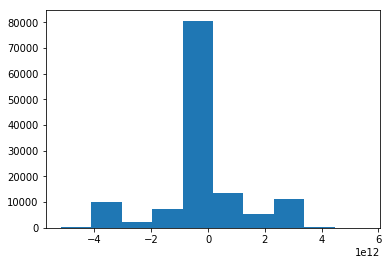

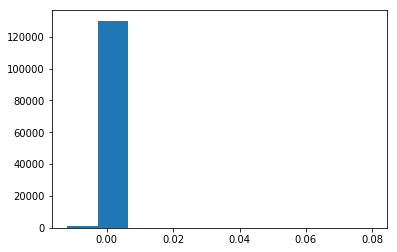

In [26]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### ROC plot to compare performance of various models and fits

In [20]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance]

#fits = [rdg_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

NameError: name 'svm_performance' is not defined

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [28]:
dir(rdg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_label_binarizer',
 '_predict_proba_lr',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'class_weight',
 'classes_',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'normalize',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [29]:
rdg.get_params()

{'alpha': 5.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [30]:
type(rdg.coef_)

numpy.ndarray

In [31]:
rdg.coef_.shape

(1, 131074)

In [32]:
print(rdg.coef_[0])

[-0.00183297 -0.00018562  0.         ... -0.00044407  0.00266302
  0.07976537]


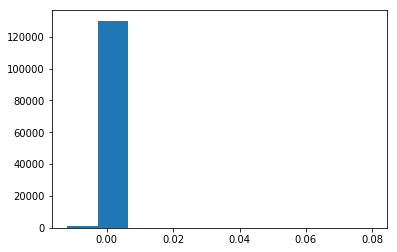

In [33]:
plt.hist(rdg.coef_[0])
plt.show()